In [1]:
# --- Cell 1: Tải các thư viện ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib
# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 2.0.3


In [2]:
# --- Cell 2: Tải dữ liệu đã xử lý ---
file_name = '/kaggle/input/kpi-processed/kpi_processed.csv'
try:
    df = pd.read_csv(file_name, index_col=0, parse_dates=True)
    print(f"Tải file '{file_name}' thành công.")
    print(f"Dữ liệu có {len(df)} hàng, kéo dài từ {df.index.min()} đến {df.index.max()}.")
    df.info()
except Exception as e:
    print(f"LỖI: Không thể tải file '{file_name}'.")
    print(e)

Tải file '/kaggle/input/kpi-processed/kpi_processed.csv' thành công.
Dữ liệu có 313186 hàng, kéo dài từ 2025-10-11 00:00:00 đến 2025-11-10 23:45:00.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313186 entries, 2025-10-11 00:00:00 to 2025-11-10 23:00:00
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   enodeb                  313186 non-null  object 
 1   cell_name               313186 non-null  object 
 2   ps_traffic_mb           313168 non-null  float64
 3   avg_rrc_connected_user  313186 non-null  float64
 4   prb_dl_used             312997 non-null  float64
 5   prb_dl_available_total  312997 non-null  float64
 6   prb_utilization         313186 non-null  float64
dtypes: float64(5), object(2)
memory usage: 19.1+ MB


In [3]:
# --- Cell 3: Xử lý dữ liệu ---
if 'df' in locals():
    FEATURE_COLS = ['ps_traffic_mb', 'avg_rrc_connected_user', 'prb_dl_used', 'prb_dl_available_total', 'prb_utilization']
    N_FEATURES = len(FEATURE_COLS)
    print(f"Dự đoán {N_FEATURES} features: {FEATURE_COLS}")
    print("Đang xử lý: Đảm bảo dữ liệu 15 phút đầy đủ cho mỗi cell...")
    all_cells = df['cell_name'].unique()
    full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15min')
    multi_index = pd.MultiIndex.from_product([all_cells, full_time_index], names=['cell_name', 'timestamp'])
    df_data_only = df[FEATURE_COLS + ['cell_name']]
    df_data_only = df_data_only.reset_index()
    print(f"Dữ liệu trước khi xử lý trùng lặp: {len(df_data_only)} hàng")
    df_grouped_unique = df_data_only.groupby(['cell_name', 'timestamp']).mean()
    print(f"Dữ liệu sau khi xử lý trùng lặp (groupby.mean): {len(df_grouped_unique)} hàng")
    df_full = df_grouped_unique.reindex(multi_index, fill_value=0)
    df_full = df_full.reset_index()
    df_full = df_full.set_index('timestamp')
    print(f"Dữ liệu gốc có {len(df)} hàng.")
    print(f"Dữ liệu đã điền đầy đủ (sau reindex) có {len(df_full)} hàng.")
    print("Hoàn tất xử lý.")
    print("\n5 dòng đầu của dữ liệu đã xử lý đầy đủ:")
    print(df_full.head())
else:
    print("Lỗi: DataFrame 'df' không tồn tại. Vui lòng chạy lại Cell 2.")

Dự đoán 5 features: ['ps_traffic_mb', 'avg_rrc_connected_user', 'prb_dl_used', 'prb_dl_available_total', 'prb_utilization']
Đang xử lý: Đảm bảo dữ liệu 15 phút đầy đủ cho mỗi cell...
Dữ liệu trước khi xử lý trùng lặp: 313186 hàng
Dữ liệu sau khi xử lý trùng lặp (groupby.mean): 303370 hàng
Dữ liệu gốc có 313186 hàng.
Dữ liệu đã điền đầy đủ (sau reindex) có 321408 hàng.
Hoàn tất xử lý.

5 dòng đầu của dữ liệu đã xử lý đầy đủ:
                    cell_name  ps_traffic_mb  avg_rrc_connected_user  \
timestamp                                                              
2025-10-11 00:00:00  EnodebA3         161.14                8.527778   
2025-10-11 00:15:00  EnodebA3           0.00                0.000000   
2025-10-11 00:30:00  EnodebA3           0.00                0.000000   
2025-10-11 00:45:00  EnodebA3           0.00                0.000000   
2025-10-11 01:00:00  EnodebA3         231.61                7.777778   

                     prb_dl_used  prb_dl_available_total  prb_utili

In [4]:
# --- Cell 4: Chia dữ liệu và Cấu hình mô hình ---
TIMESTEPS_PER_HOUR = 4
TIMESTEPS_PER_DAY = 24 * TIMESTEPS_PER_HOUR
INPUT_DAYS = 2
INPUT_STEPS = INPUT_DAYS * TIMESTEPS_PER_DAY
OUTPUT_DAYS = 1
OUTPUT_STEPS = OUTPUT_DAYS * TIMESTEPS_PER_DAY
print(f"Cấu hình mô hình: Input {INPUT_STEPS} bước (2 ngày), Output {OUTPUT_STEPS} bước (1 ngày).")

if 'df_full' in locals():
    total_duration = df_full.index.max() - df_full.index.min()
    train_end_time = df_full.index.min() + total_duration * 0.7
    val_end_time = df_full.index.min() + total_duration * 0.9
    
    train_df = df_full[df_full.index < train_end_time]
    val_df = df_full[(df_full.index >= train_end_time) & (df_full.index < val_end_time)]
    test_df = df_full[df_full.index >= val_end_time]
    
    print(f"Kích thước tập Train: {train_df.shape}")
    print(f"Kích thước tập Val:   {val_df.shape}")
    print(f"Kích thước tập Test:  {test_df.shape}")
else:
    print("Lỗi: DataFrame 'df_full' không tồn tại.")

Cấu hình mô hình: Input 192 bước (2 ngày), Output 96 bước (1 ngày).
Kích thước tập Train: (224964, 6)
Kích thước tập Val:   (64260, 6)
Kích thước tập Test:  (32184, 6)


In [5]:
# --- Cell 5: Chuẩn hóa (Scaling) Dữ liệu ---
if 'train_df' in locals():
    train_df = train_df.replace([np.inf, -np.inf], 0).fillna(0)
    val_df = val_df.replace([np.inf, -np.inf], 0).fillna(0)
    test_df = test_df.replace([np.inf, -np.inf], 0).fillna(0)

    scaler = MinMaxScaler()
    scaler.fit(train_df[FEATURE_COLS])

    joblib.dump(scaler, 'scaler.gz')

    train_cells = train_df['cell_name']
    val_cells = val_df['cell_name']
    test_cells = test_df['cell_name']

    train_scaled_data = scaler.transform(train_df[FEATURE_COLS])
    val_scaled_data = scaler.transform(val_df[FEATURE_COLS])
    test_scaled_data = scaler.transform(test_df[FEATURE_COLS])

    scaled_train_df = pd.DataFrame(train_scaled_data, columns=FEATURE_COLS, index=train_df.index)
    scaled_train_df['cell_name'] = train_cells

    scaled_val_df = pd.DataFrame(val_scaled_data, columns=FEATURE_COLS, index=val_df.index)
    scaled_val_df['cell_name'] = val_cells

    scaled_test_df = pd.DataFrame(test_scaled_data, columns=FEATURE_COLS, index=test_df.index)
    scaled_test_df['cell_name'] = test_cells
    
    print("Hoàn tất scaling dữ liệu và lưu scaler vào 'scaler.gz'.")
else:
    print("Lỗi: DataFrame 'train_df' không tồn tại.")

Hoàn tất scaling dữ liệu và lưu scaler vào 'scaler.gz'.


In [6]:
# --- Cell 6: Hàm tạo cửa sổ (Windowing) ---
def create_windows(data_df, input_steps, output_steps, feature_cols):
    X, y = [], []
    grouped = data_df.groupby('cell_name')
    total_cells = len(grouped)
    print(f"Bắt đầu tạo cửa sổ cho {total_cells} cell...")
    
    for cell_id, cell_data in grouped:
        cell_features = cell_data[feature_cols].values
        total_samples = len(cell_features)
        total_window_len = input_steps + output_steps
        
        for i in range(total_samples - total_window_len + 1):
            input_end = i + input_steps
            output_end = input_end + output_steps
            
            window_X = cell_features[i:input_end, :]
            window_y = cell_features[input_end:output_end, :]
            
            X.append(window_X)
            y.append(window_y)
            
    print(f"Hoàn tất tạo cửa sổ. Đã tạo {len(X)} mẫu.")
    return np.array(X), np.array(y)

In [7]:
# --- Cell 7: Áp dụng hàm Windowing và làm phẳng dữ liệu ---
if 'scaled_train_df' in locals():
    print("--- Đang tạo mẫu Train ---")
    X_train, y_train = create_windows(scaled_train_df, INPUT_STEPS, OUTPUT_STEPS, FEATURE_COLS)
    print("\n--- Đang tạo mẫu Validation ---")
    X_val, y_val = create_windows(scaled_val_df, INPUT_STEPS, OUTPUT_STEPS, FEATURE_COLS)
    print("\n--- Đang tạo mẫu Test ---")
    X_test, y_test = create_windows(scaled_test_df, INPUT_STEPS, OUTPUT_STEPS, FEATURE_COLS)

    # Làm phẳng dữ liệu (Flatten)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    y_train_flat = y_train.reshape(y_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    y_val_flat = y_val.reshape(y_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    # y_test sẽ được giữ nguyên dạng 3D để so sánh

    print("\n--- Kích thước dữ liệu sau khi làm phẳng ---")
    print(f"X_train_flat shape: {X_train_flat.shape}")
    print(f"y_train_flat shape: {y_train_flat.shape}")
    print(f"X_val_flat shape:   {X_val_flat.shape}")
    print(f"y_val_flat shape:   {y_val_flat.shape}")
    print(f"X_test_flat shape:  {X_test_flat.shape}")
    print(f"y_test shape:       {y_test.shape}")
else:
    print("Lỗi: Dữ liệu đã scale không tồn tại.")

--- Đang tạo mẫu Train ---
Bắt đầu tạo cửa sổ cho 108 cell...
Hoàn tất tạo cửa sổ. Đã tạo 193968 mẫu.

--- Đang tạo mẫu Validation ---
Bắt đầu tạo cửa sổ cho 108 cell...
Hoàn tất tạo cửa sổ. Đã tạo 33264 mẫu.

--- Đang tạo mẫu Test ---
Bắt đầu tạo cửa sổ cho 108 cell...
Hoàn tất tạo cửa sổ. Đã tạo 1188 mẫu.

--- Kích thước dữ liệu sau khi làm phẳng ---
X_train_flat shape: (193968, 960)
y_train_flat shape: (193968, 480)
X_val_flat shape:   (33264, 960)
y_val_flat shape:   (33264, 480)
X_test_flat shape:  (1188, 960)
y_test shape:       (1188, 96, 5)


In [ ]:
# --- Cell 8: Xây dựng và Huấn luyện mô hình XGBoost GPU với Early Stopping ---

if 'X_train_flat' in locals():
    print("Bắt đầu huấn luyện XGBoost (GPU) với vòng lặp thủ công...")

    # Danh sách để lưu các mô hình con
    xgb_models = []
    n_outputs = y_train_flat.shape[1]

    for i in range(n_outputs):
        print(f"\n=== Huấn luyện mô hình cho output {i+1}/{n_outputs} ===")

        # --- Cấu hình XGBoost GPU ---
        xgb_model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=6,
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            eval_metric='rmse',

            # GPU (chuẩn XGBoost >= 2.0.3)
            tree_method="hist",
            device="cuda"
        )

        # Eval set cho early stopping
        eval_set = [(X_val_flat, y_val_flat[:, i])]

        # Huấn luyện mô hình con (bật verbose để in loss từng vòng)
        xgb_model.fit(
            X_train_flat,
            y_train_flat[:, i],
            eval_set=eval_set,
            early_stopping_rounds=50,
            verbose=True    # 🔥 In ra loss mỗi iteration
        )

        xgb_models.append(xgb_model)

    print(f"\nHoàn tất huấn luyện {len(xgb_models)} mô hình XGBoost trên GPU!")

    # Lưu danh sách mô hình
    joblib.dump(xgb_models, 'xgboost_model_gpu.joblib')
    print("Đã lưu danh sách mô hình vào 'xgboost_model_gpu.joblib'")

else:
    print("Lỗi: Thiếu dữ liệu đã xử lý (X_train_flat).")


Bắt đầu huấn luyện XGBoost (GPU) với vòng lặp thủ công...

=== Huấn luyện mô hình cho output 1/480 ===


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.05703
[1]	validation_0-rmse:0.05233
[2]	validation_0-rmse:0.04816
[3]	validation_0-rmse:0.04445
[4]	validation_0-rmse:0.04120
[5]	validation_0-rmse:0.03832
[6]	validation_0-rmse:0.03581
[7]	validation_0-rmse:0.03362
[8]	validation_0-rmse:0.03172
[9]	validation_0-rmse:0.03006
[10]	validation_0-rmse:0.02865
[11]	validation_0-rmse:0.02745
[12]	validation_0-rmse:0.02640
[13]	validation_0-rmse:0.02552
[14]	validation_0-rmse:0.02477
[15]	validation_0-rmse:0.02414
[16]	validation_0-rmse:0.02360
[17]	validation_0-rmse:0.02315
[18]	validation_0-rmse:0.02277
[19]	validation_0-rmse:0.02246
[20]	validation_0-rmse:0.02220
[21]	validation_0-rmse:0.02198
[22]	validation_0-rmse:0.02180
[23]	validation_0-rmse:0.02163
[24]	validation_0-rmse:0.02150
[25]	validation_0-rmse:0.02138
[26]	validation_0-rmse:0.02128
[27]	validation_0-rmse:0.02120
[28]	validation_0-rmse:0.02114
[29]	validation_0-rmse:0.02108
[30]	validation_0-rmse:0.02103
[31]	validation_0-rmse:0.02099
[32]	validation_0-

In [11]:
# --- Cell 9: Đánh giá trên tập Test ---
if 'xgb_models' in locals():
    print("--- Đánh giá XGBoost trên tập Test ---")
    
    # Dự đoán bằng cách lặp qua từng mô hình con
    y_pred_list = [model.predict(X_test_flat) for model in xgb_models]
    # Ghép các kết quả dự đoán lại
    y_pred_flat = np.stack(y_pred_list, axis=1)

    y_test_flat = y_test.reshape(y_test.shape[0], -1)

    test_loss_mse = mean_squared_error(y_test_flat, y_pred_flat)
    test_metric_mae = mean_absolute_error(y_test_flat, y_pred_flat)

    print(f"  Test Loss (MSE): {test_loss_mse:.6f}")
    print(f"  Test MAE (Mean Absolute Error): {test_metric_mae:.6f}")
    
    with open('xgboost_loss.txt', 'w') as f:
        f.write(f"MSE: {test_loss_mse}\n")
        f.write(f"MAE: {test_metric_mae}\n")
    print("Đã lưu loss vào file 'xgboost_loss.txt'.")
else:
    print("Lỗi: Mô hình XGBoost (xgb_models) chưa được huấn luyện.")

--- Đánh giá XGBoost trên tập Test ---
  Test Loss (MSE): 0.007738
  Test MAE (Mean Absolute Error): 0.033783
Đã lưu loss vào file 'xgboost_loss.txt'.


--- Trực quan hóa kết quả dự đoán XGBoost trên tập Test ---

--- So sánh Mẫu #1 ---


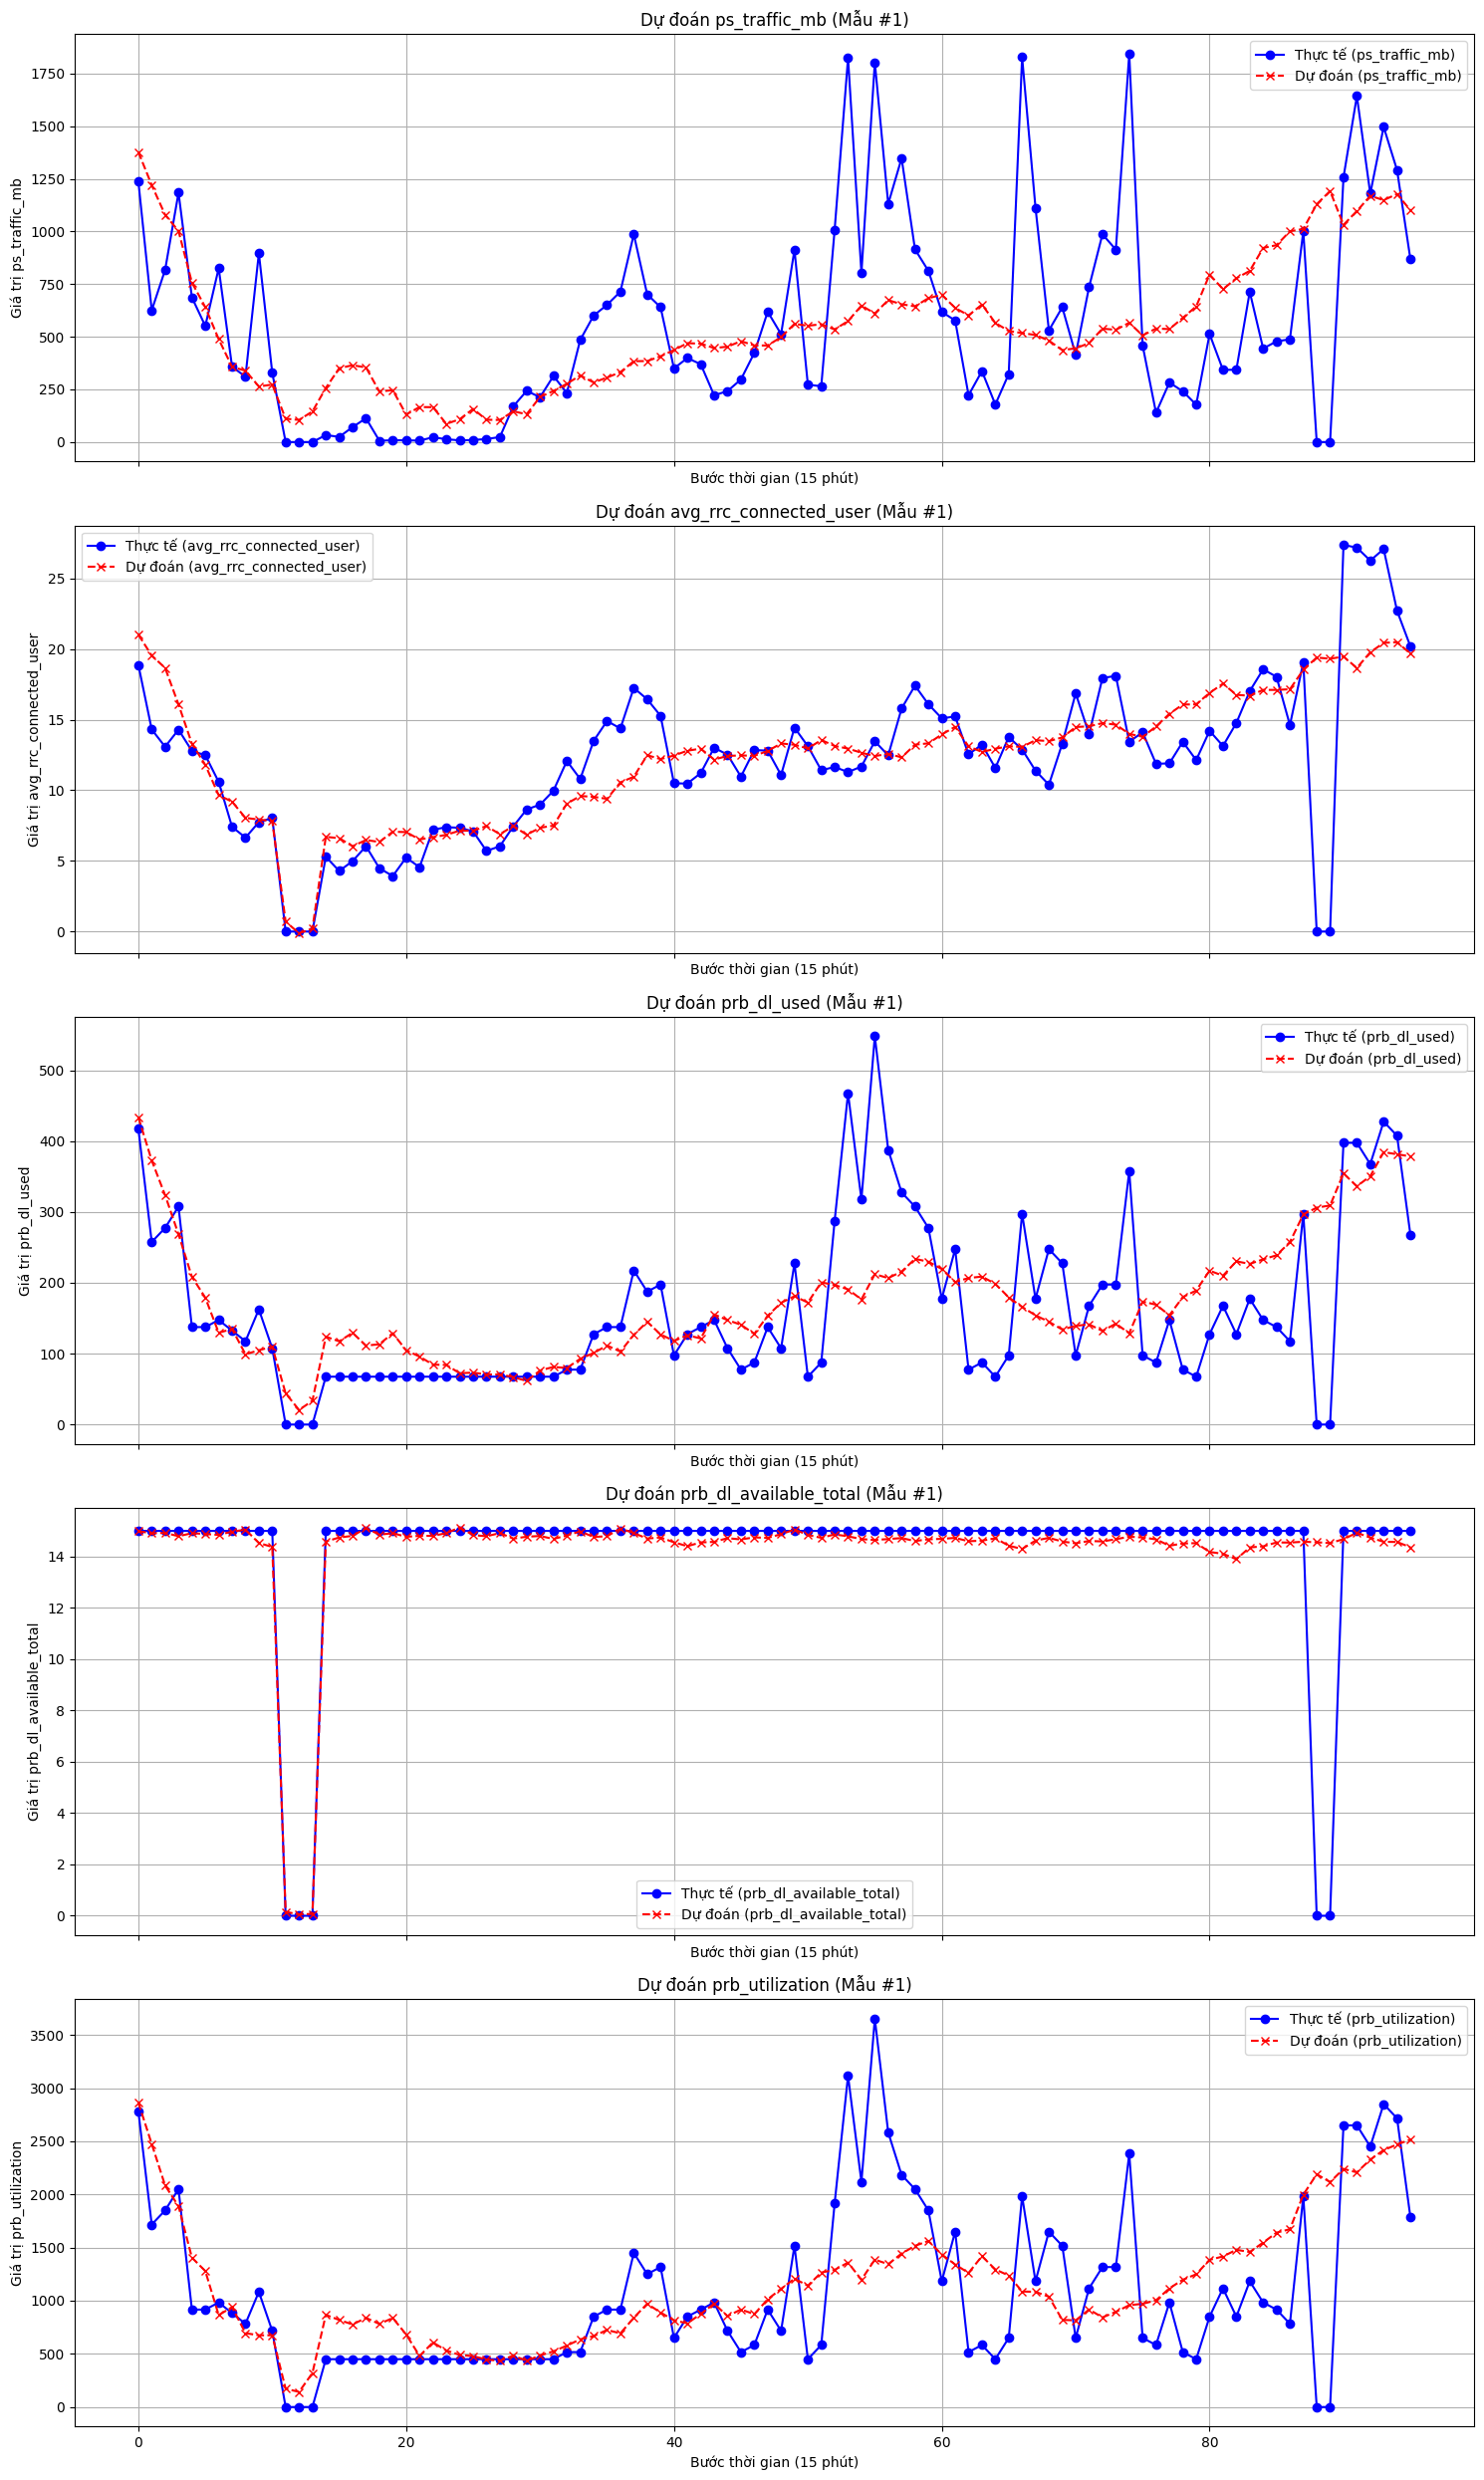


--- So sánh Mẫu #2 ---


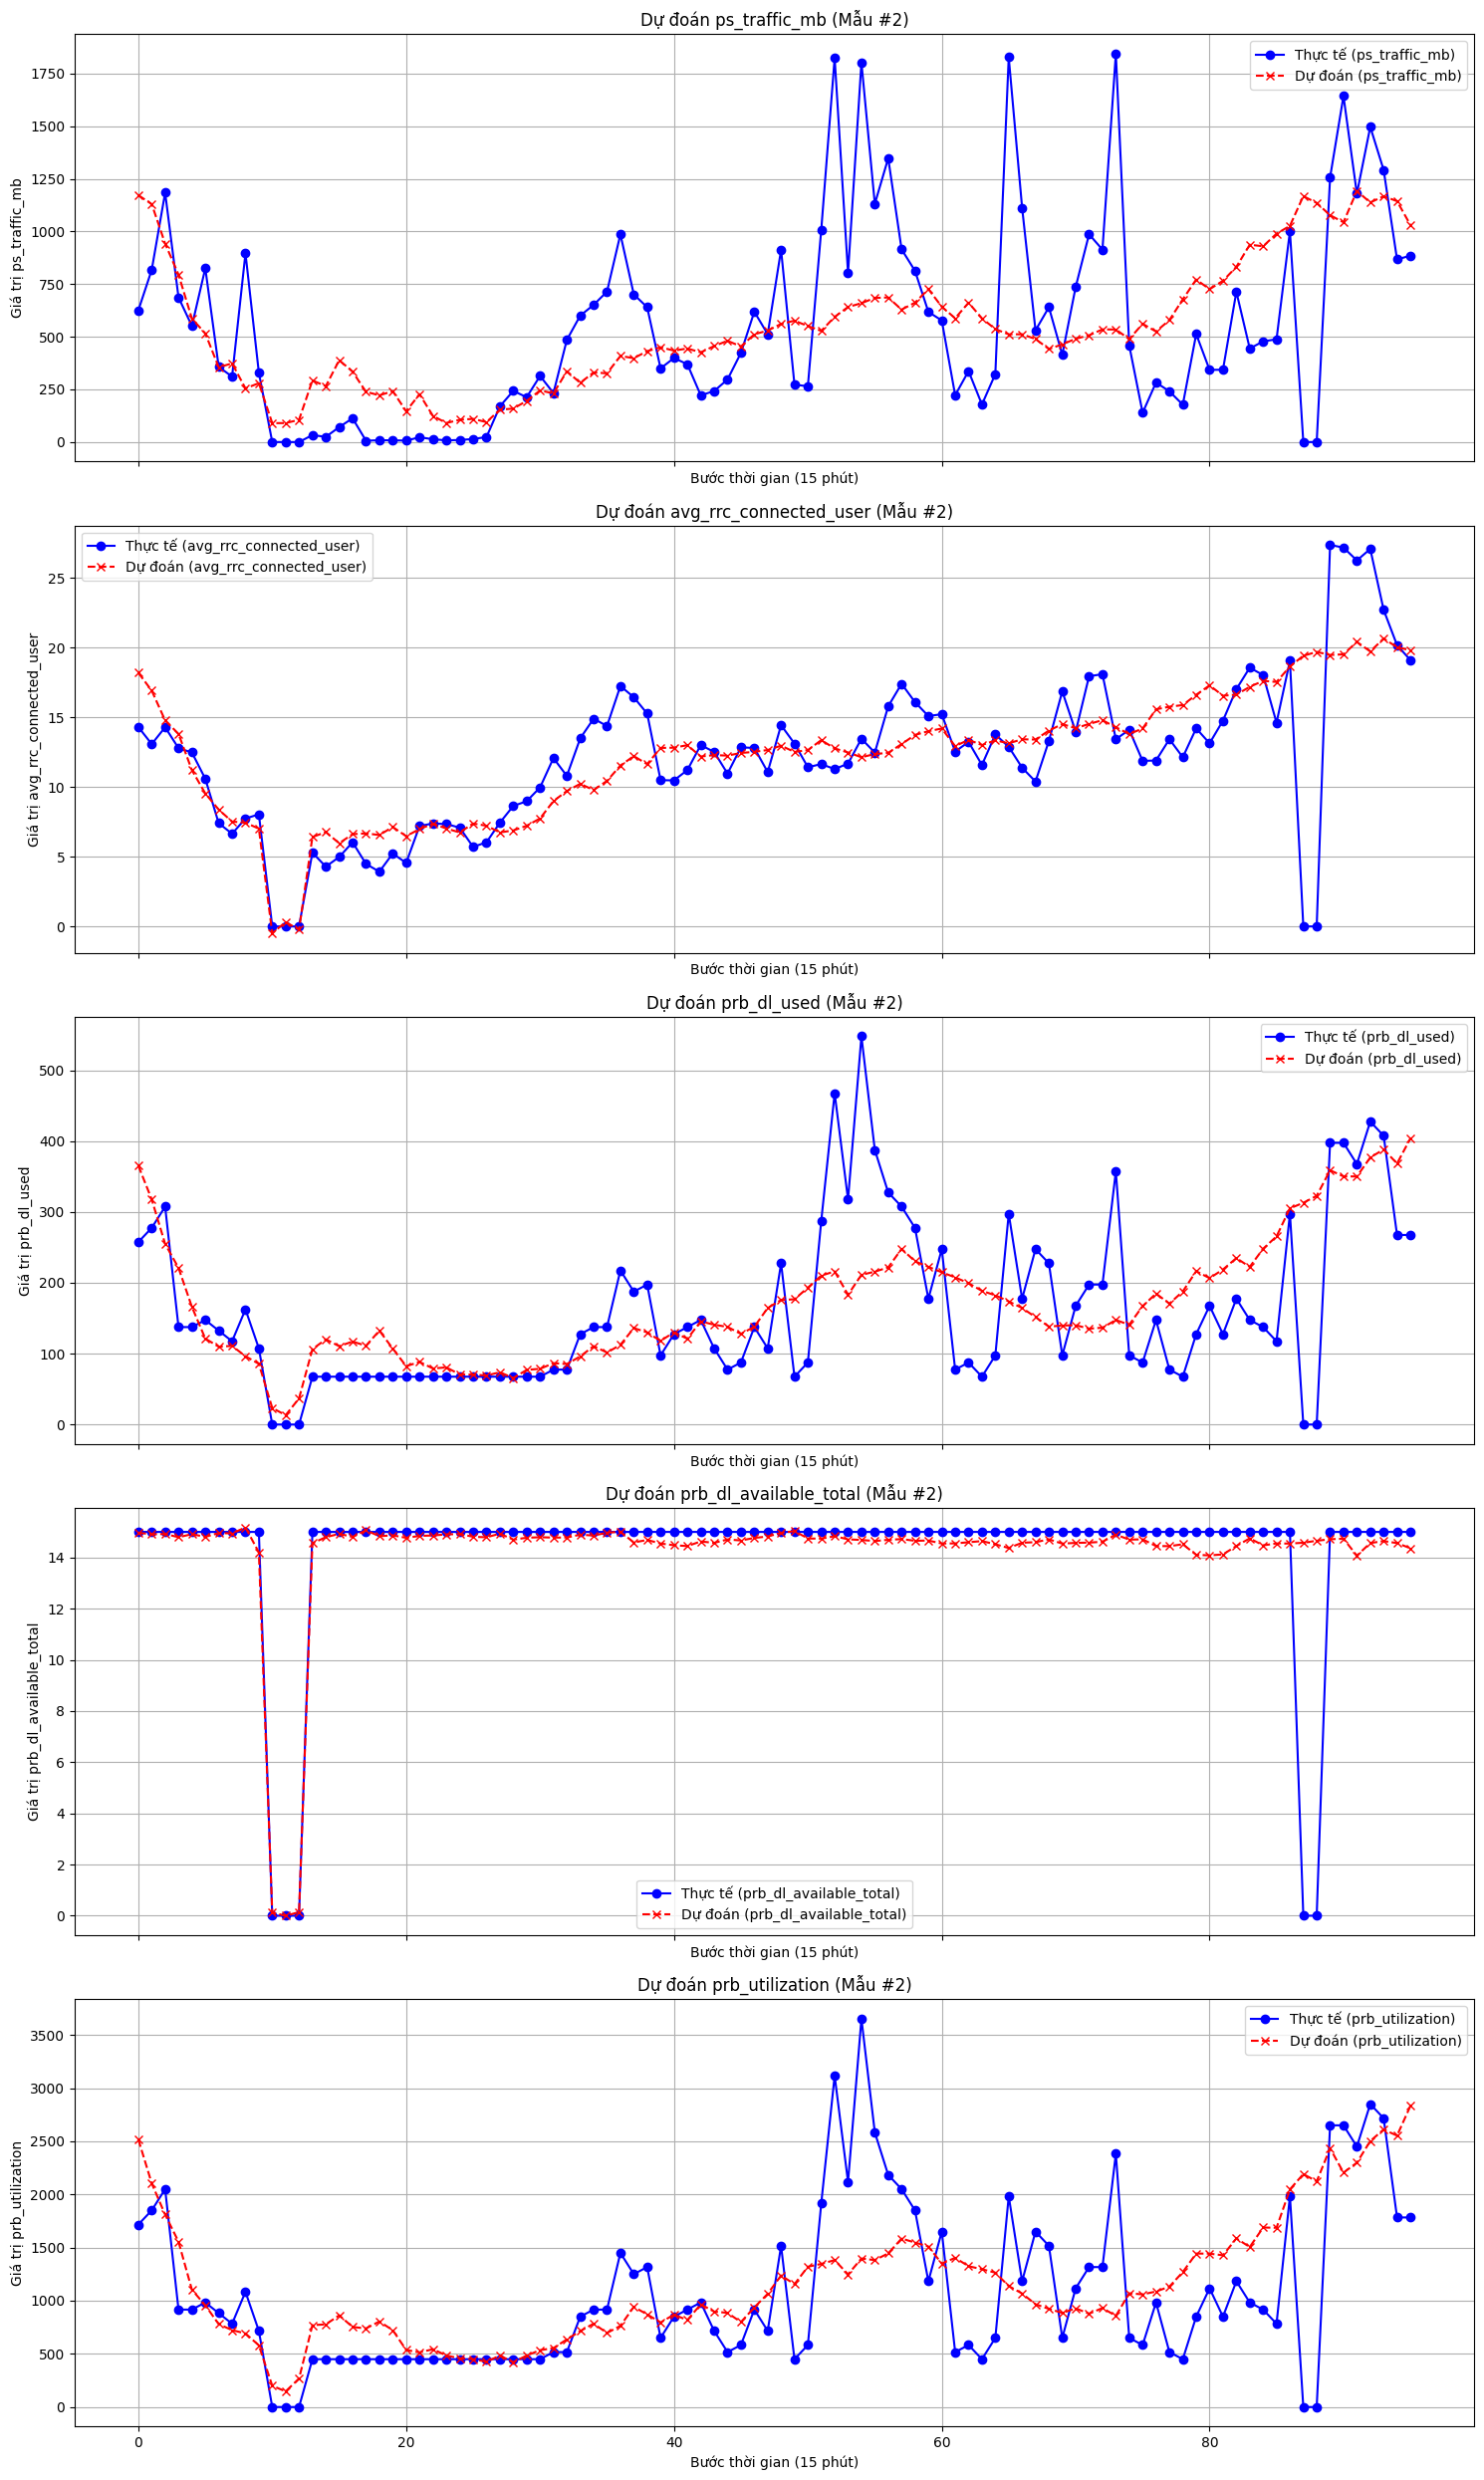


--- So sánh Mẫu #3 ---


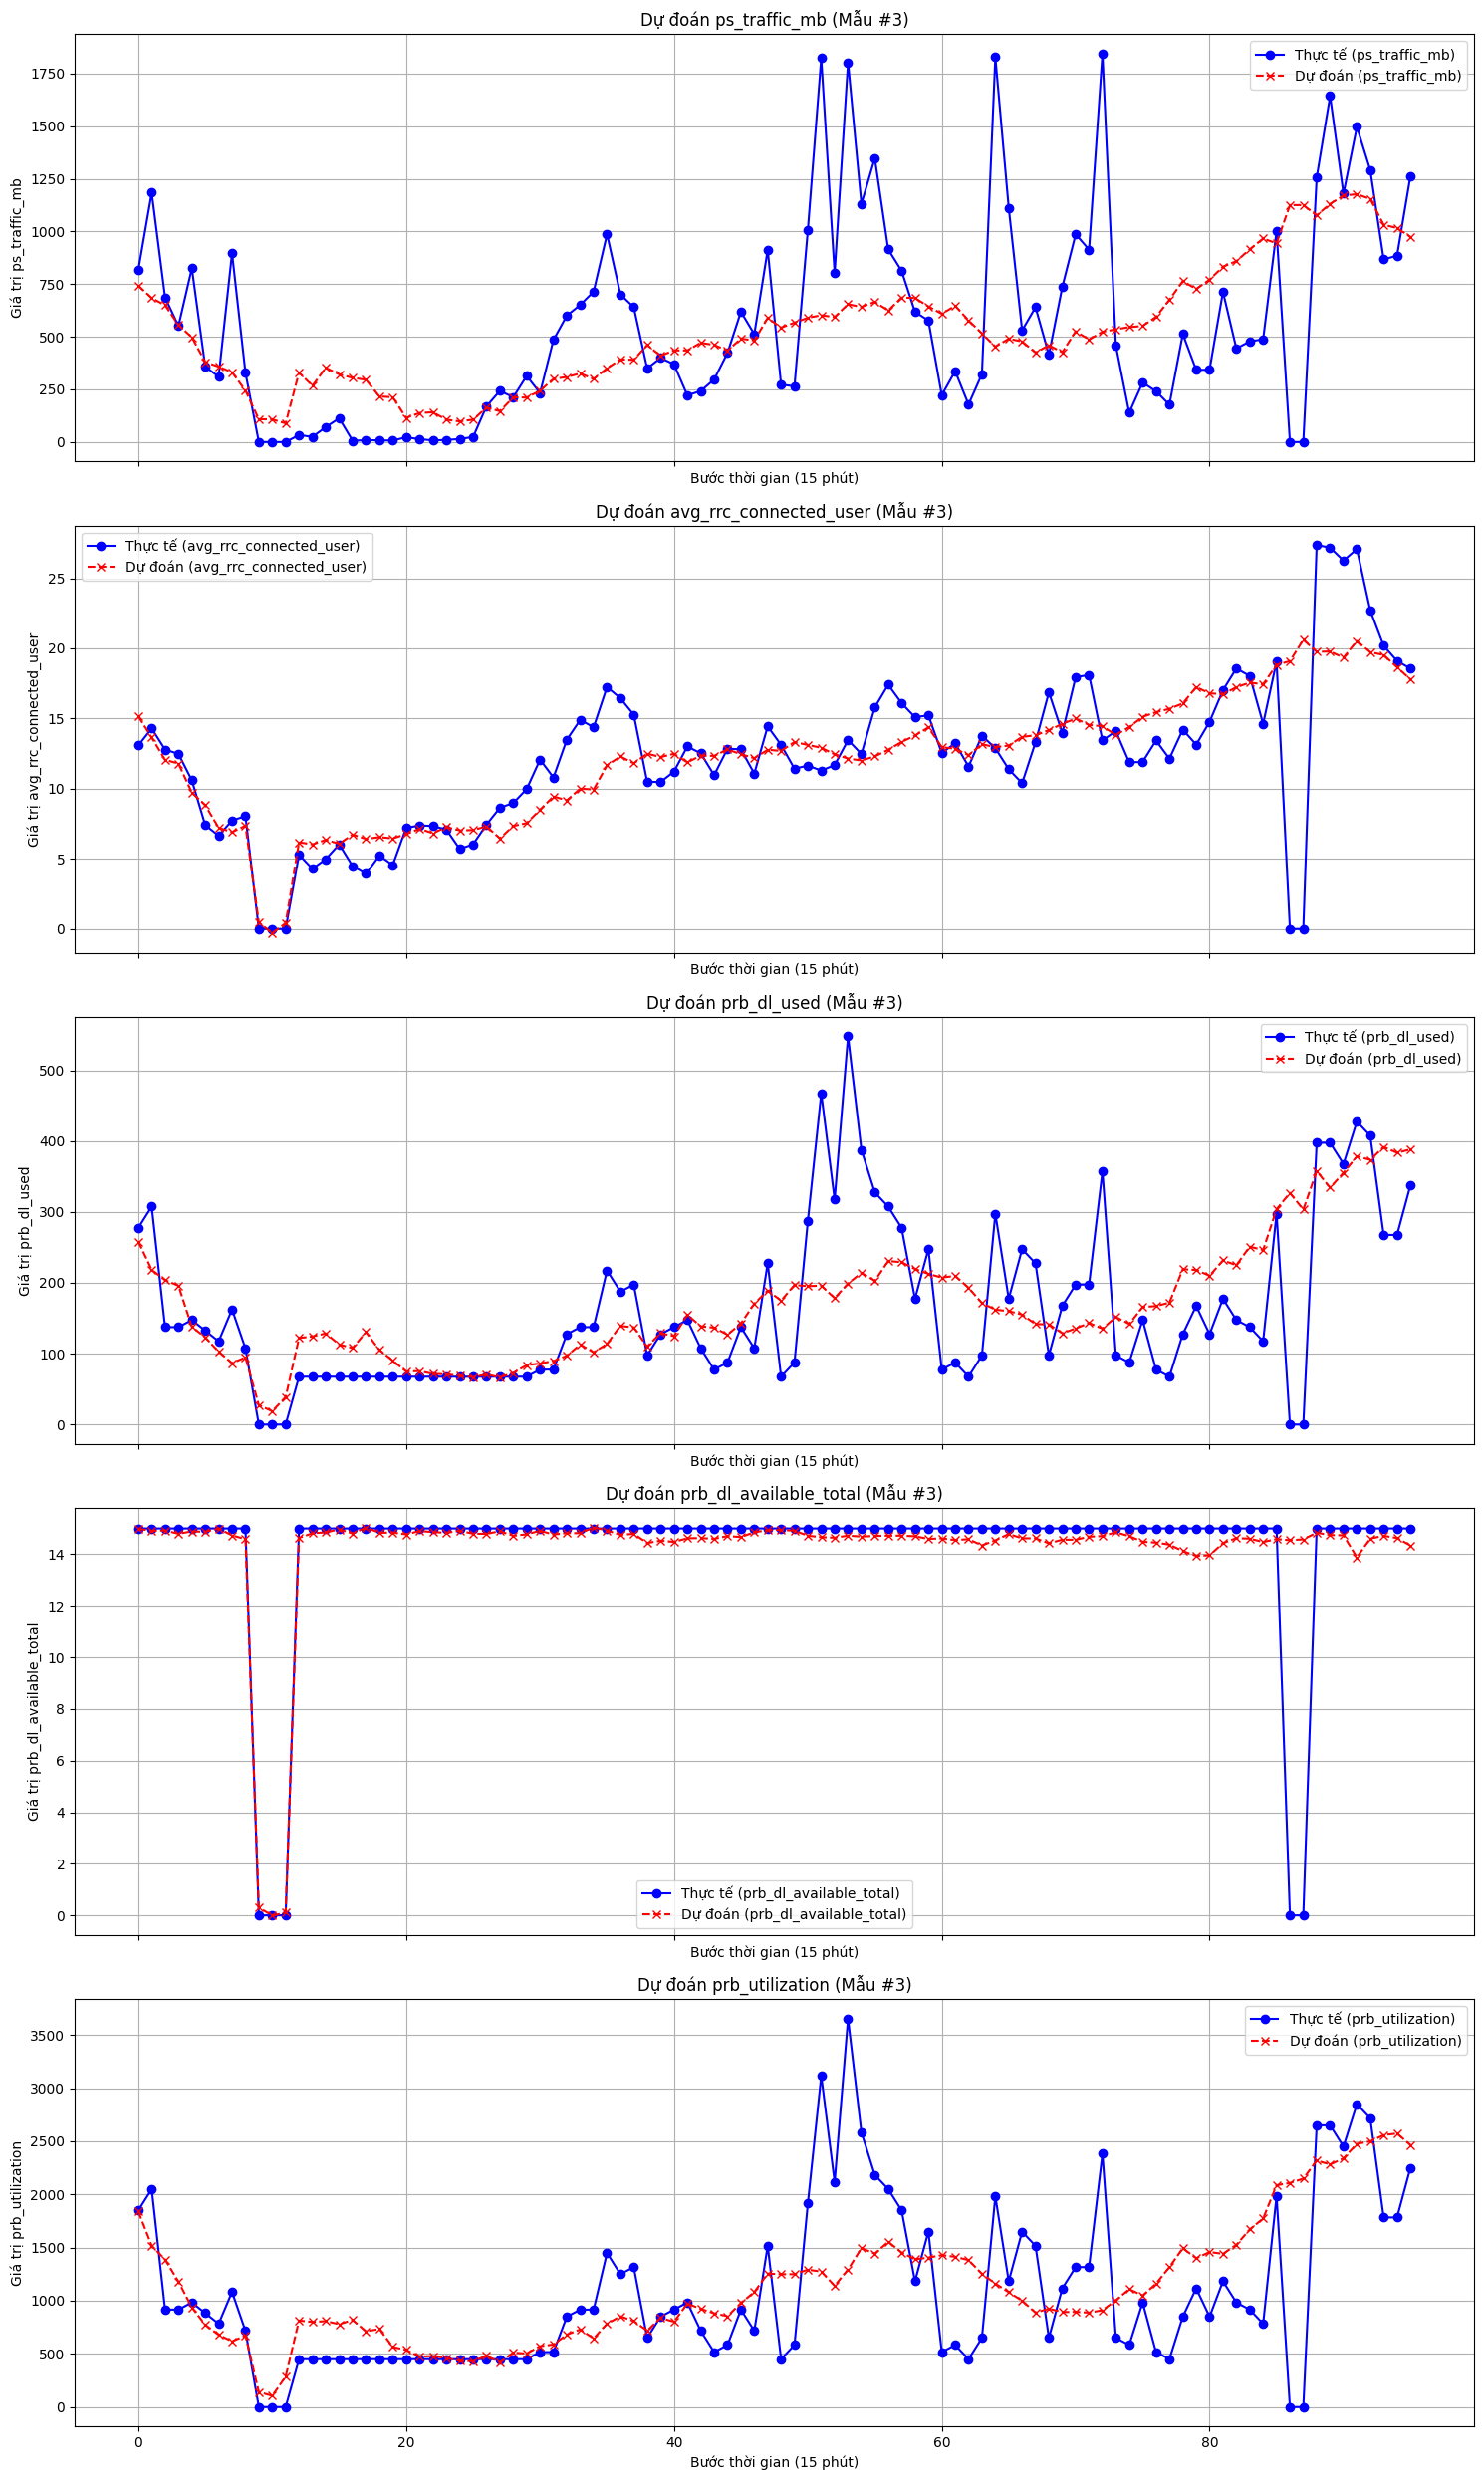


--- So sánh Mẫu #4 ---


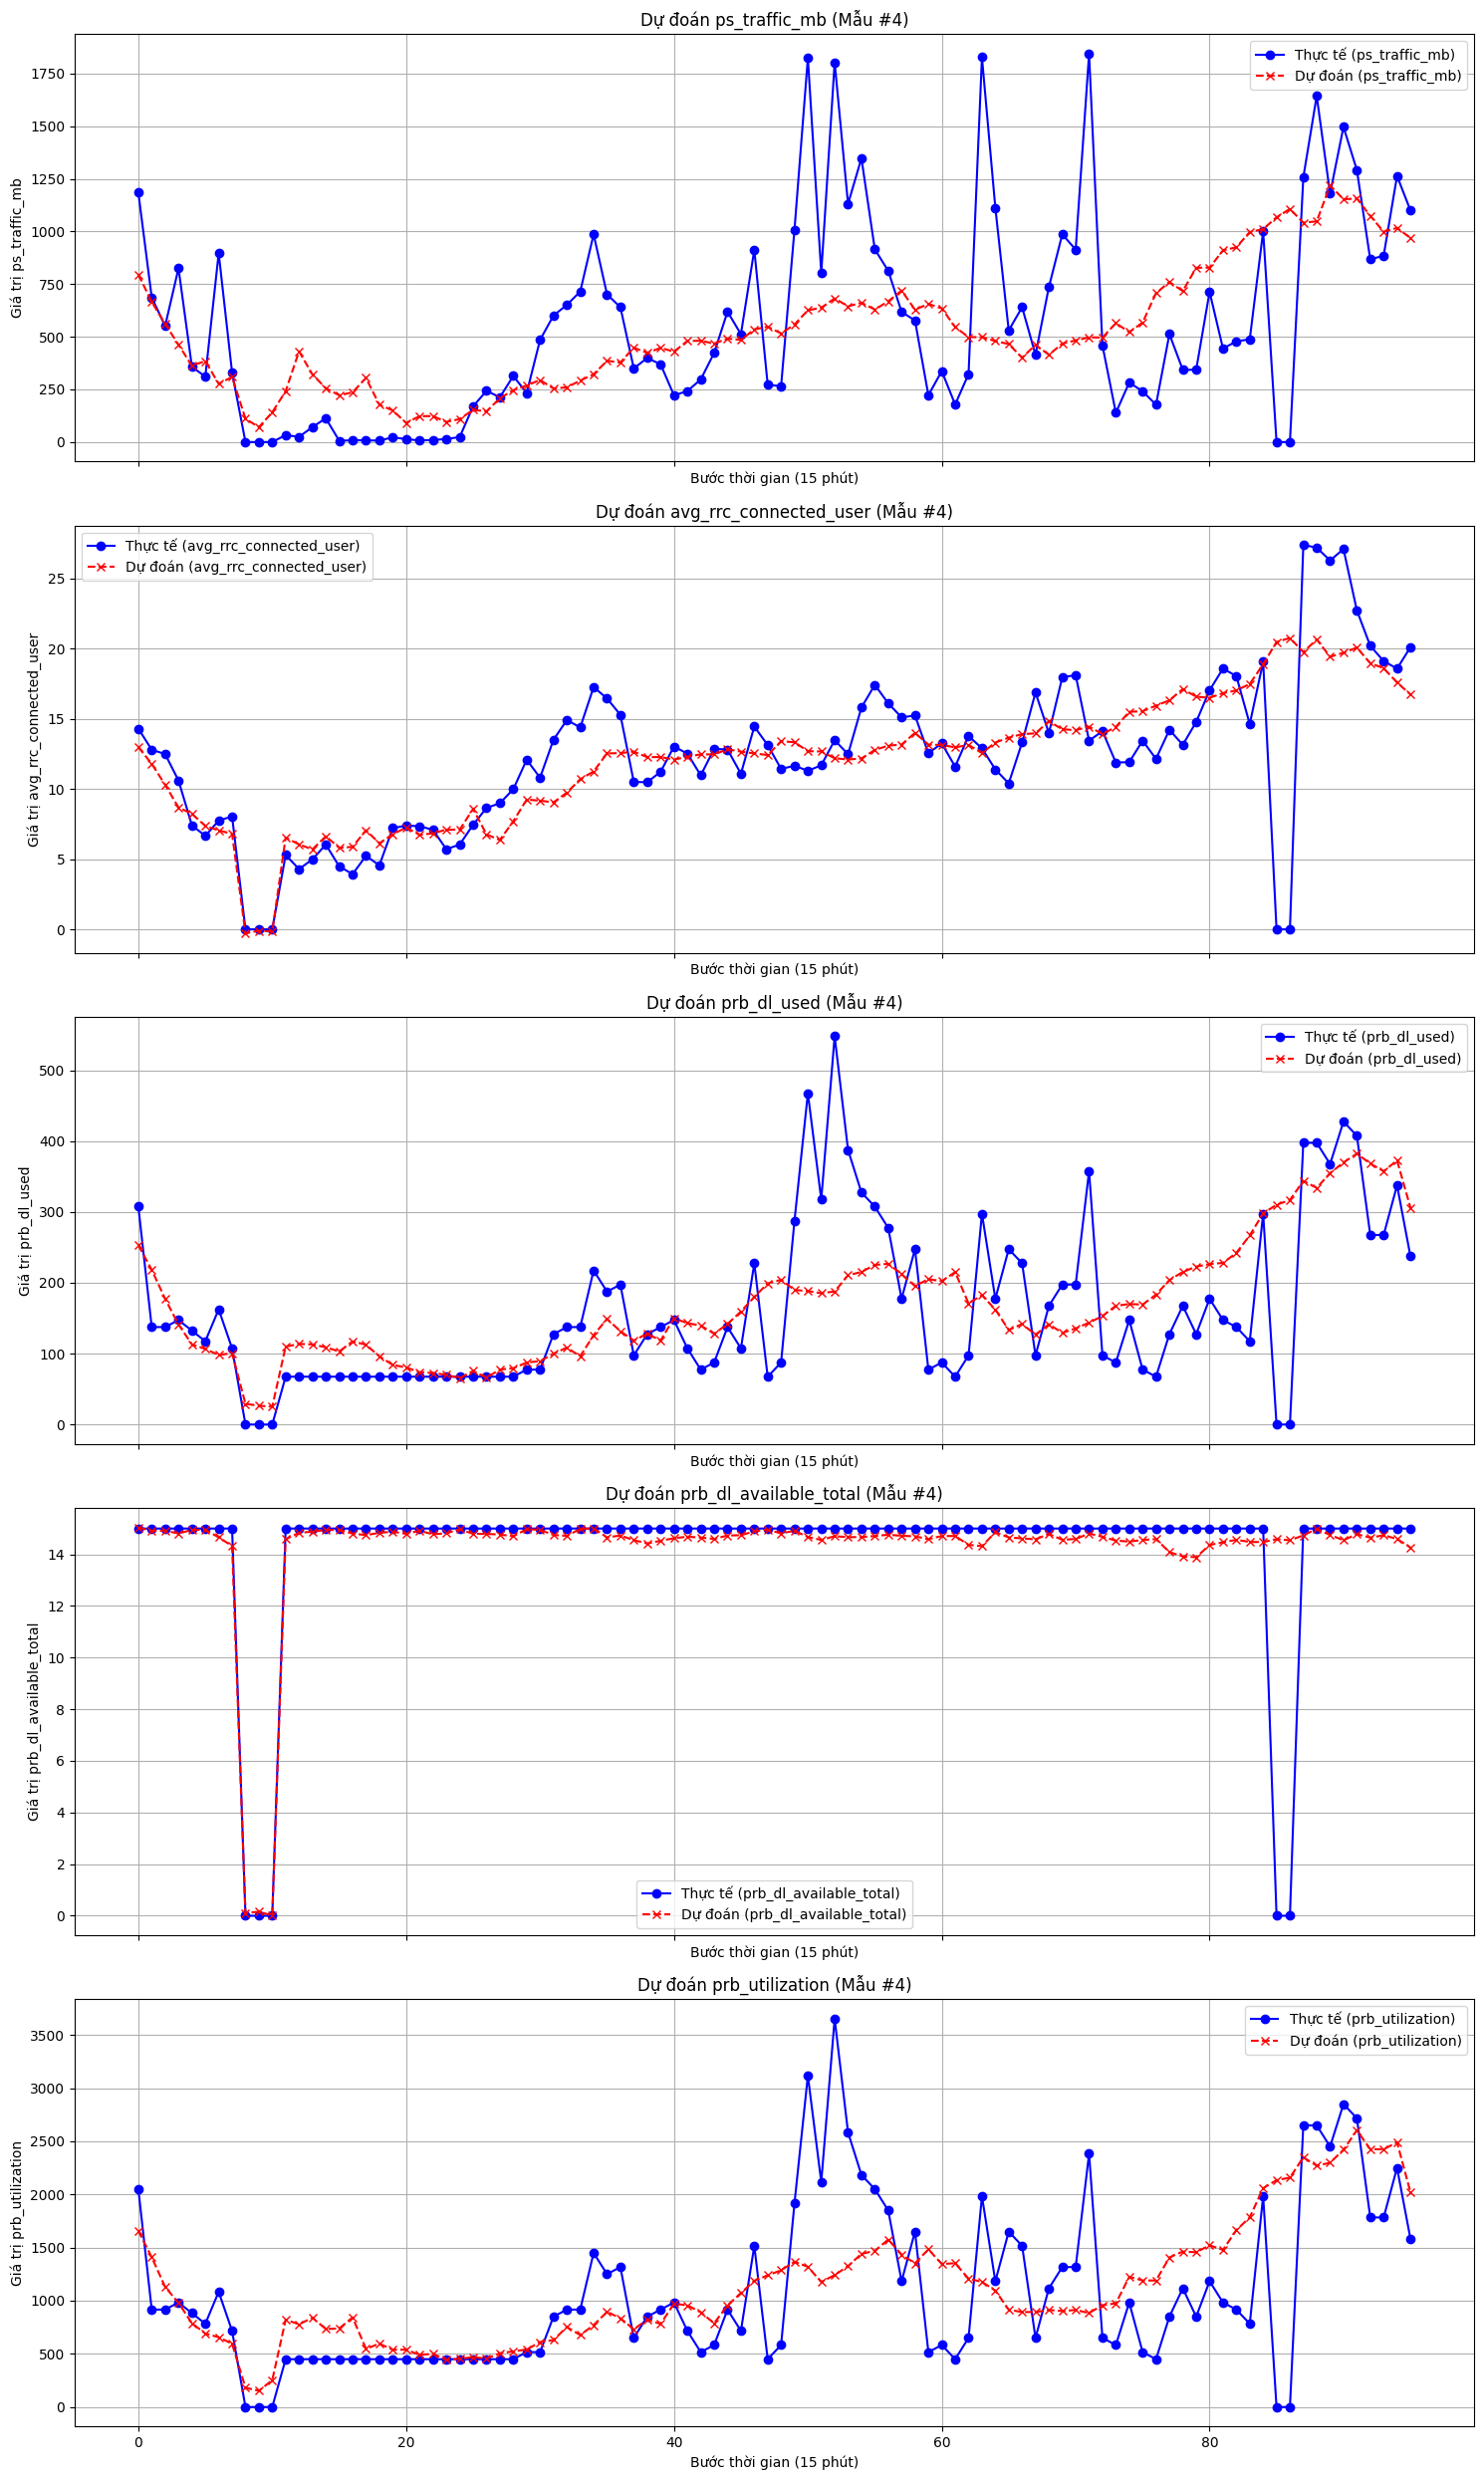


--- So sánh Mẫu #5 ---


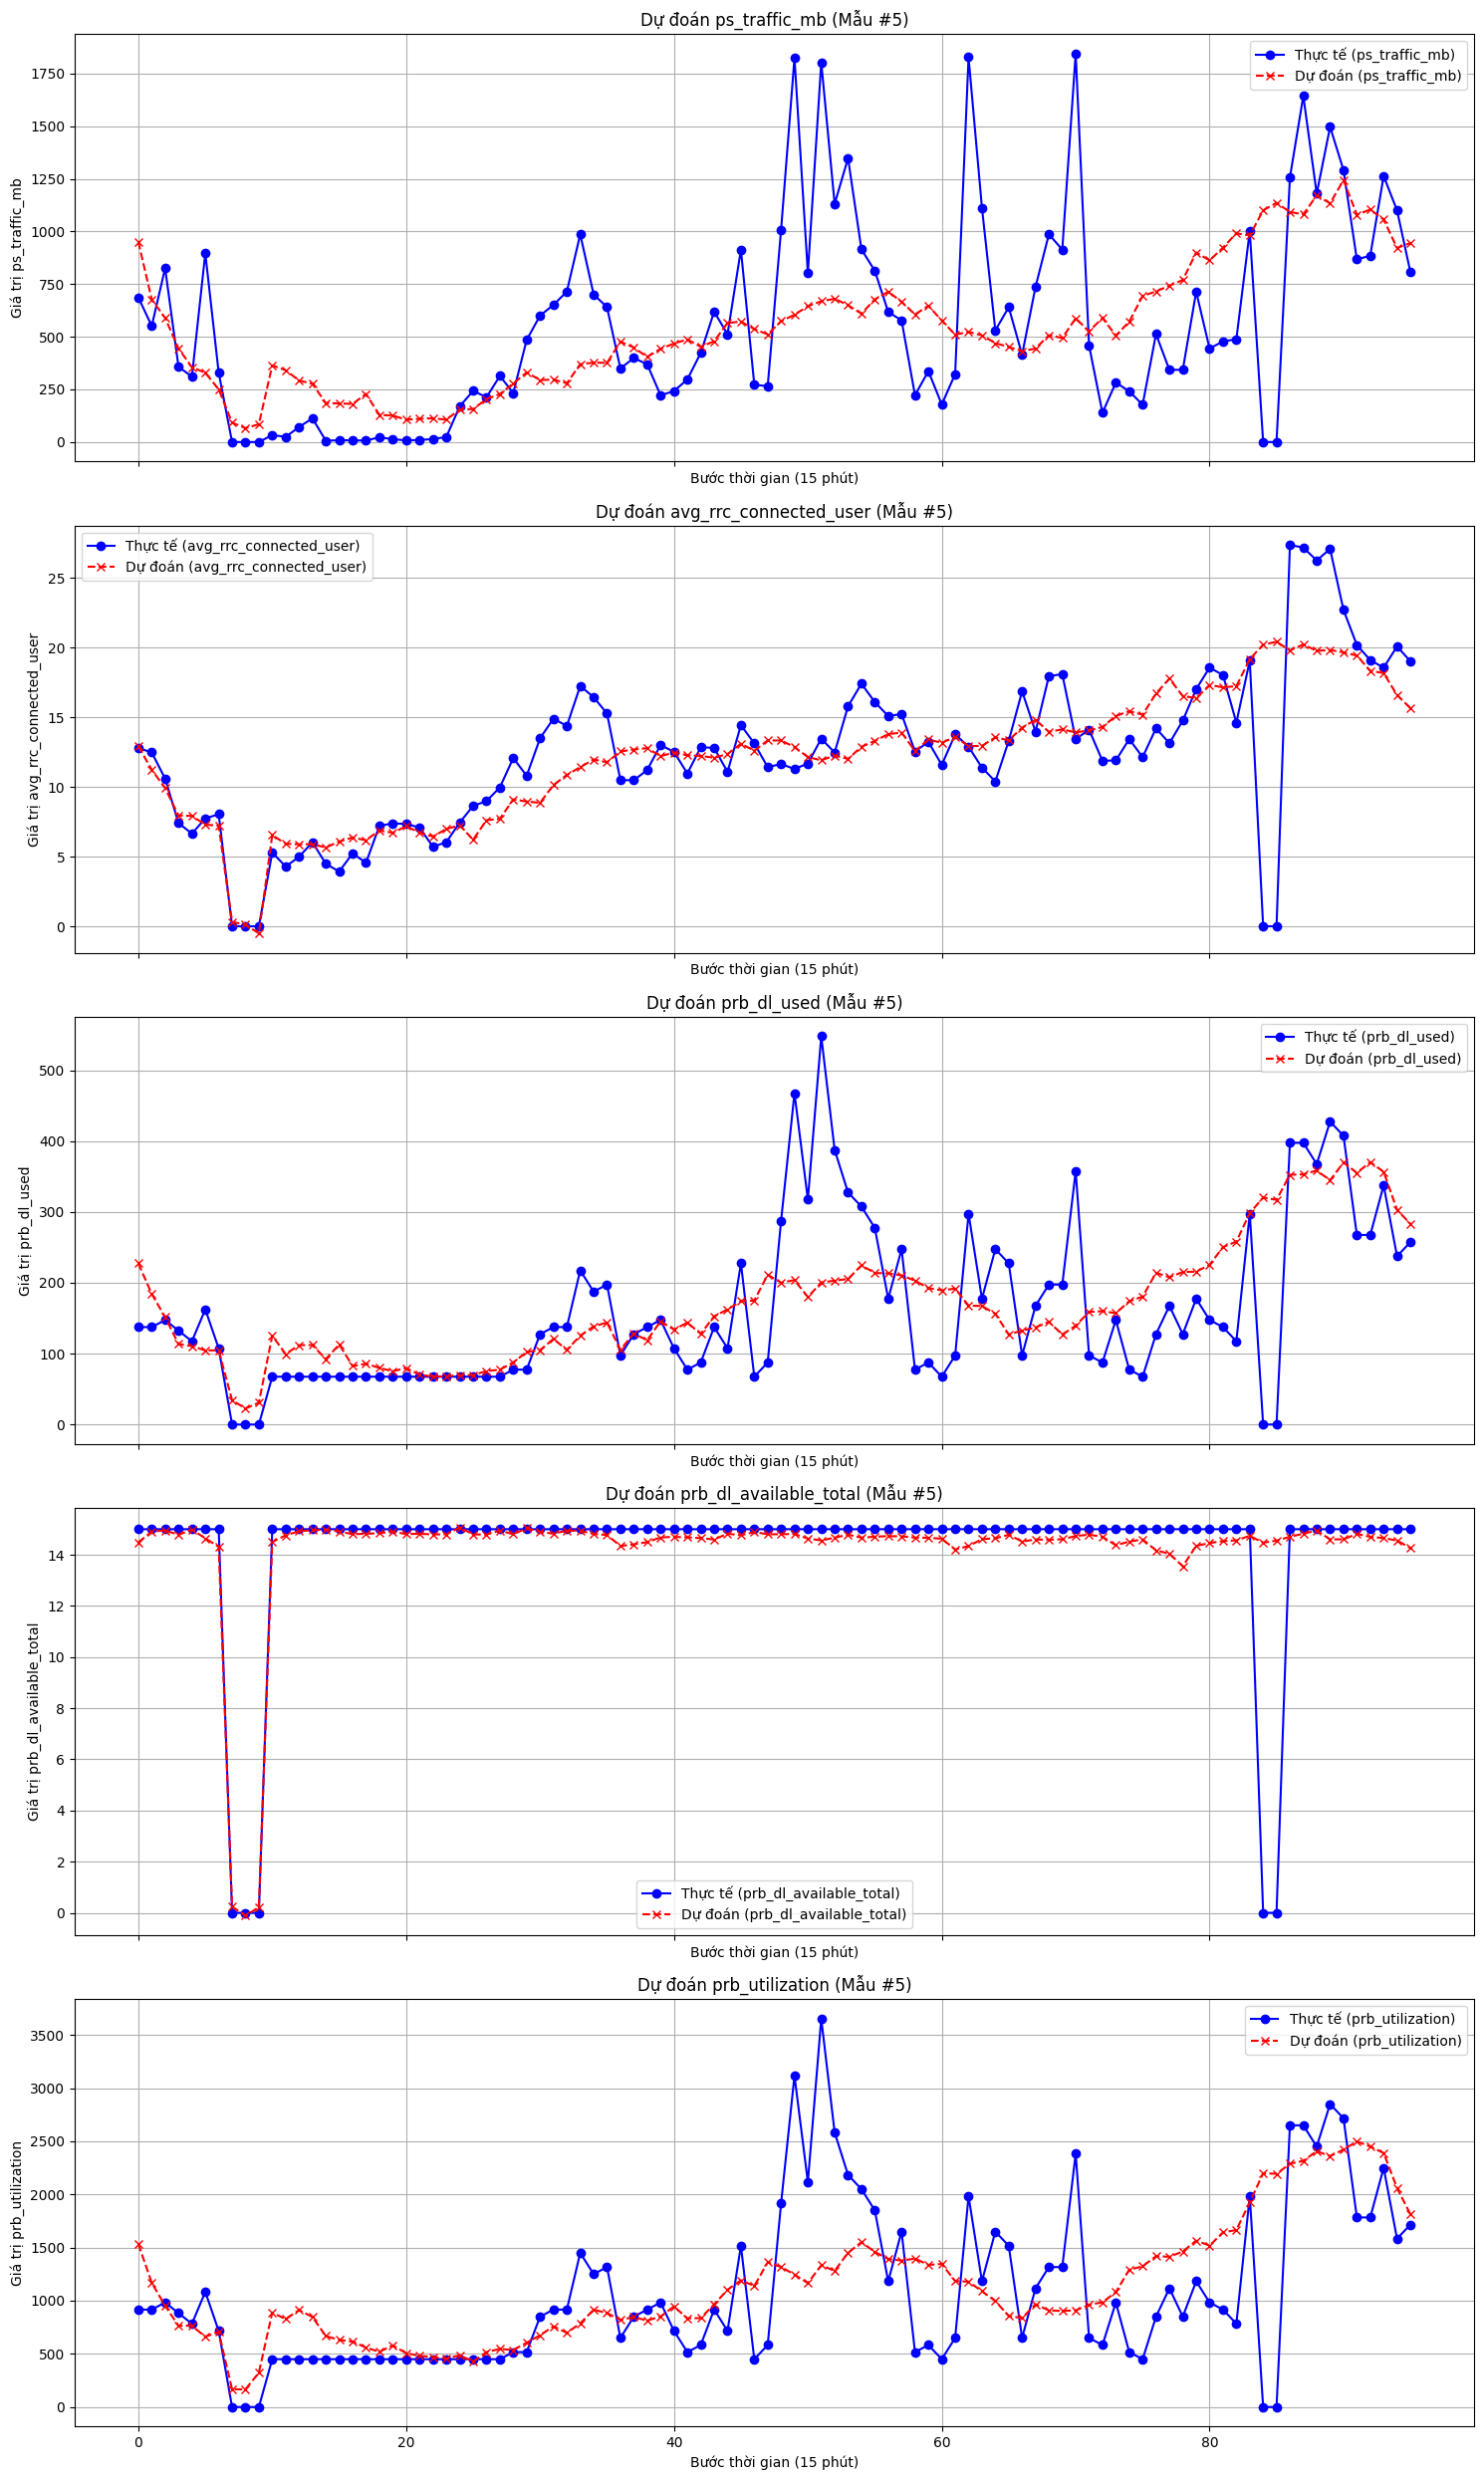

In [12]:
# --- Cell 10: So sánh kết quả dự đoán với giá trị thực tế ---
if 'xgb_models' in locals() and 'X_test' in locals() and 'scaler' in locals():
    print("--- Trực quan hóa kết quả dự đoán XGBoost trên tập Test ---")
    num_samples_to_plot = min(5, X_test.shape[0])
    if num_samples_to_plot > 0:
        # Lấy subset của test data
        X_test_subset_flat = X_test_flat[:num_samples_to_plot]

        # Dự đoán với subset
        y_pred_list = [model.predict(X_test_subset_flat) for model in xgb_models]
        y_pred_flat = np.stack(y_pred_list, axis=1)
        y_pred_scaled = y_pred_flat.reshape(num_samples_to_plot, OUTPUT_STEPS, N_FEATURES)

        y_test_subset = y_test[:num_samples_to_plot]

        y_true_reshaped = y_test_subset.reshape(-1, N_FEATURES)
        y_true_original = scaler.inverse_transform(y_true_reshaped)
        y_true_original = y_true_original.reshape(num_samples_to_plot, OUTPUT_STEPS, N_FEATURES)

        y_pred_reshaped = y_pred_scaled.reshape(-1, N_FEATURES)
        y_pred_original = scaler.inverse_transform(y_pred_reshaped)
        y_pred_original = y_pred_original.reshape(num_samples_to_plot, OUTPUT_STEPS, N_FEATURES)

        for i in range(num_samples_to_plot):
            print(f"\n--- So sánh Mẫu #{i+1} ---")
            fig, axes = plt.subplots(N_FEATURES, 1, figsize=(15, 5 * N_FEATURES), sharex=True)
            if N_FEATURES == 1: axes = [axes]

            for j, feature_name in enumerate(FEATURE_COLS):
                ax = axes[j]
                ax.plot(y_true_original[i, :, j], label=f'Thực tế ({feature_name})', color='blue', marker='o', linestyle='-')
                ax.plot(y_pred_original[i, :, j], label=f'Dự đoán ({feature_name})', color='red', marker='x', linestyle='--')
                ax.set_title(f'Dự đoán {feature_name} (Mẫu #{i+1})')
                ax.set_xlabel('Bước thời gian (15 phút)')
                ax.set_ylabel(f'Giá trị {feature_name}')
                ax.legend()
                ax.grid(True)
            
            plt.tight_layout()
            plt.show()
    else:
        print("Không có mẫu nào trong X_test để dự đoán.")
else:
    print("Lỗi: Không thể trực quan hóa.")